# Gestión de carteras

# Importamos librerias

In [5]:
import math
import numpy as np
import scipy.stats as scs
import statsmodels.api as sm
import yfinance as yf
import pandas as pd
from pylab import mpl, plt

## Definimos las características de los gráficos 

In [6]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

## Recuperamos precios y calculamos rentabilidades 

In [7]:
symbols = ["MSFT","AAPL","GLD","SPY"]
tickers = yf.Tickers(symbols) 

In [8]:
data = tickers.history(start='2019-01-01',end='2020-06-29').Close.dropna()

[*********************100%***********************]  4 of 4 completed


<AxesSubplot:xlabel='Date'>

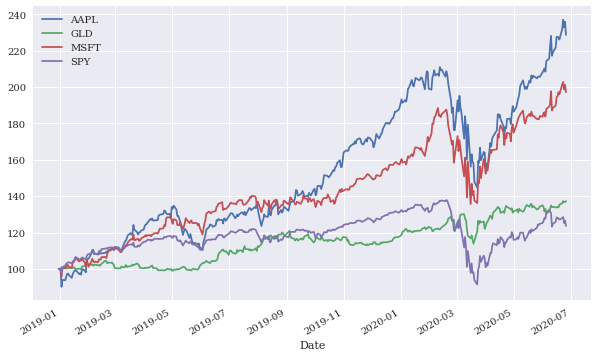

In [9]:
(data / data.iloc[0] * 100).plot(figsize=(10, 6))

array([[<AxesSubplot:title={'center':'AAPL'}>,
        <AxesSubplot:title={'center':'GLD'}>],
       [<AxesSubplot:title={'center':'MSFT'}>,
        <AxesSubplot:title={'center':'SPY'}>]], dtype=object)

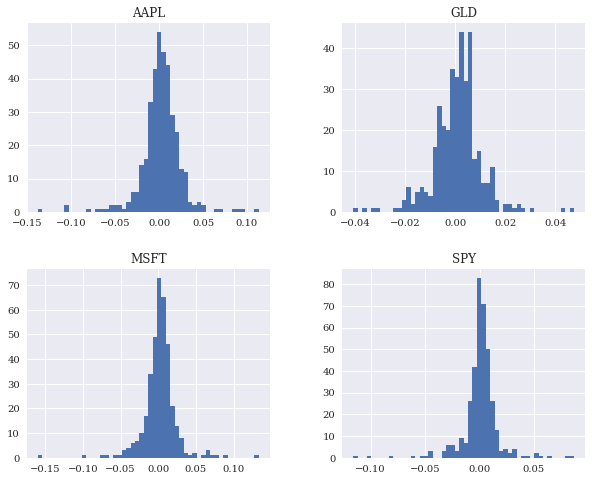

In [10]:
rets = np.log(data / data.shift(1))
rets.hist(bins=50, figsize=(10, 8))

## Creamos una cartera aleatoria con cuatro títulos 

Nos guardamos la cantidad de activos en una variable

In [11]:
noa = len(symbols)

Calculamos la media anualizada, en días laborables

In [12]:
rets.mean() * 252

AAPL    0.555939
GLD     0.213280
MSFT    0.456446
SPY     0.142344
dtype: float64

Covarianza entre activos anualizada

In [13]:
rets.cov() * 252

,AAPL,GLD,MSFT,SPY
AAPL,0.139667,-0.000609,0.110795,0.089055
GLD,-0.000609,0.023540,0.001436,0.001873
MSFT,0.110795,0.001436,0.124938,0.087808
SPY,0.089055,0.001873,0.087808,0.077408


Vamos a generar unos pesos random para la cartera

In [14]:
weights = np.random.random(noa)
print(weights)

[0.67494524 0.29465132 0.06628071 0.27059593]


Normalizamos los pesos, es decir que sumen 1

In [15]:
weights /= np.sum(weights)
print(weights)

[0.51661622 0.22553185 0.05073254 0.20711939]


In [16]:
np.sum(weights)

1.0

Calculamos la rentabilidad de la cartera

In [17]:
np.dot(rets.mean().T *252, weights)   

0.3879473164046415

Calculamos la volatilidad de la cartera

In [18]:
np.dot(weights.T, np.dot(rets.cov() * 252, weights))

0.06889270950209322

In [19]:
np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

0.26247420730824816

Transformamos la rentabilidad y la volatilidad en una función

In [20]:
def port_ret(weights, rets):
    return np.dot(rets.mean().T *252, weights)

In [21]:
def port_vol(weights,rets):
    return np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

Creamos una función para los pesos

In [22]:
def pesos_aleatorios(noa):
    pesos = np.random.random(noa)
    pesos /= np.sum(pesos)
    return pesos

Generamos 2500 carteras aleatorias

In [23]:
prets = [] 
pvols = [] 
pweights = []

In [24]:
for p in range (2500):
    weights = pesos_aleatorios(noa)
    prets.append(port_ret(weights,rets=rets))
    pvols.append(port_vol(weights,rets=rets))
    pweights.append(weights)

In [25]:
prets = np.array(prets) 
pvols = np.array(pvols)

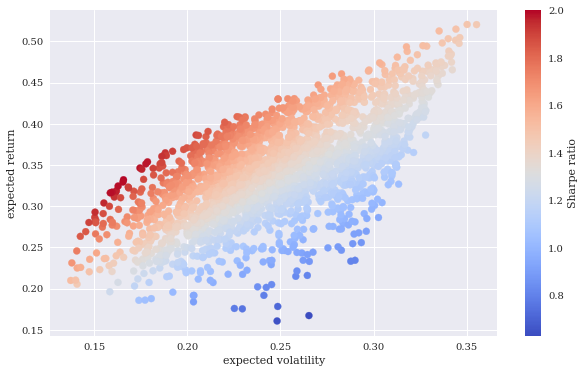

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols, marker='o', cmap='coolwarm')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

# Cartera eficiente para c=0

Vamos a ver que existe un metodo mediante optimización cuadrática

In [28]:
import scipy.optimize as sco

In [29]:
def min_func_sharpe(weights,rets):
    return -port_ret(weights,rets) / port_vol(weights,rets)

In [30]:
bnds = tuple((0, 1) for x in range(noa))
cons = ({'type': 'eq', 'fun': lambda x:np.sum(x) - 1})
eweights = np.array(noa * [1. / noa,])
eweights

array([0.25, 0.25, 0.25, 0.25])

In [31]:
min_func_sharpe(eweights,rets=rets)

-1.4063124955358692

In [32]:
opts = sco.minimize(lambda x : min_func_sharpe(x,rets=rets), eweights, method='SLSQP', bounds=bnds, constraints=cons)
opts

     fun: -2.0468562712738834
     jac: array([ 3.04085016e-03, -1.33636594e-03,  1.61463618e-02,  1.50109300e+00])
 message: 'Optimization terminated successfully'
    nfev: 22
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.3049236, 0.6950764, 0.       , 0.       ])

In [33]:
opts['x'].round(3)

array([0.305, 0.695, 0.   , 0.   ])

In [44]:
rentabilidad = port_ret(opts['x'],rets=rets).round(3)
rentabilidad

0.169

In [45]:
volatilidad = port_vol(opts['x'],rets=rets).round(3)
volatilidad

0.141

In [46]:
sharpe = rentabilidad / volatilidad
sharpe

1.1985815602836882

# Cartera de Mínima Varianza

In [47]:
optv = sco.minimize(lambda x : port_vol(x,rets=rets), eweights, method='SLSQP', bounds=bnds, constraints=cons)
optv

     fun: 0.09502115614469589
     jac: array([0.10271967, 0.09496516, 0.10995459, 0.09505828])
 message: 'Optimization terminated successfully'
    nfev: 40
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([5.31259065e-18, 3.98674798e-01, 0.00000000e+00, 6.01325202e-01])

In [48]:
optv['x'].round(3)

array([0.   , 0.399, 0.   , 0.601])

In [50]:
rentabilidad = port_ret(opts['x'],rets=rets).round(3)
rentabilidad 

0.169

In [51]:
volatilidad = port_vol(opts['x'],rets=rets).round(3)
volatilidad

0.141

In [53]:
sharpe = rentabilidad / volatilidad
sharpe

1.1985815602836882

# Frontera eficiente

In [54]:
cons = ({'type': 'eq', 'fun': lambda x:  port_ret(x,rets=rets) - tret},
                 {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

In [55]:
trets = np.linspace(0.05, 0.2, 50)
tvols = []
for tret in trets:
    res = sco.minimize(lambda x : port_vol(x,rets=rets), eweights, method='SLSQP',bounds=bnds, constraints=cons)  
    tvols.append(res['fun'])
tvols = np.array(tvols)

In [56]:
print(tvols)

[0.0964881  0.09595391 0.09553883 0.09524443 0.09507181 0.09502165
 0.09509415 0.09528901 0.09560549 0.09603673 0.09657525 0.09720676
 0.09792256 0.09872027 0.09959879 0.10055564 0.10158862 0.10269543
 0.10387371 0.10512134 0.10643502 0.10781319 0.10925313 0.11075243
 0.11230877 0.11391967 0.11558303 0.11729639 0.11905781 0.12086508
 0.12271621 0.12460948 0.12654227 0.12851356 0.13052129 0.13256382
 0.13464197 0.13684493 0.1392115  0.14173351 0.14440282 0.14721135
 0.15015136 0.15321526 0.15639577 0.15968592 0.16307947 0.16656921
 0.17014975 0.17381546]


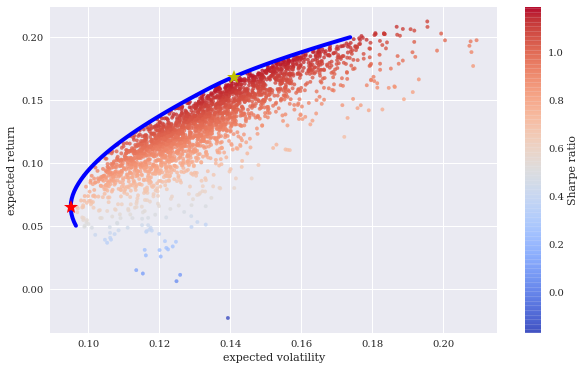

In [57]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols, marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(tvols, trets, 'b', lw=4.0)
plt.plot(port_vol(opts['x'],rets=rets), port_ret(opts['x'],rets=rets),'y*', markersize=15.0)
plt.plot(port_vol(optv['x'],rets=rets), port_ret(optv['x'],rets=rets),'r*', markersize=15.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

# Linea del mercado de capitales

In [58]:
import scipy.interpolate as sci

In [59]:
ind = np.argmin(tvols)
print(ind)

5


In [60]:
evols = tvols[ind:]
erets = trets[ind:]

In [61]:
tck = sci.splrep(evols, erets)
tck

(array([0.09502165, 0.09502165, 0.09502165, 0.09502165, 0.09528901,
        0.09560549, 0.09603673, 0.09657525, 0.09720676, 0.09792256,
        0.09872027, 0.09959879, 0.10055564, 0.10158862, 0.10269543,
        0.10387371, 0.10512134, 0.10643502, 0.10781319, 0.10925313,
        0.11075243, 0.11230877, 0.11391967, 0.11558303, 0.11729639,
        0.11905781, 0.12086508, 0.12271621, 0.12460948, 0.12654227,
        0.12851356, 0.13052129, 0.13256382, 0.13464197, 0.13684493,
        0.1392115 , 0.14173351, 0.14440282, 0.14721135, 0.15015136,
        0.15321526, 0.15639577, 0.15968592, 0.16307947, 0.16656921,
        0.17381546, 0.17381546, 0.17381546, 0.17381546]),
 array([0.06530612, 0.07011369, 0.07132117, 0.07515353, 0.07779671,
        0.08087666, 0.08385285, 0.08690219, 0.08994198, 0.09298729,
        0.09603496, 0.09908487, 0.10213618, 0.10518952, 0.10824174,
        0.11129789, 0.1143526 , 0.11740867, 0.12046524, 0.123522  ,
        0.12657965, 0.12963707, 0.13269538, 0.13575357, 0.

In [62]:
def f(x):
    return sci.splev(x, tck, der=0)
def df(x):
    return sci.splev(x, tck, der=1)

In [63]:
def equations(p, rf=0.01):
    eq1 = rf - p[0]  
    eq2 = rf + p[1] * p[2] - f(p[2])  
    eq3 = p[1] - df(p[2])  
    return eq1, eq2, eq3

In [64]:
opt = sco.fsolve(equations, [0.01, 0.5, 0.15]) 

In [65]:
opt

array([0.01      , 1.12498128, 0.14402574])

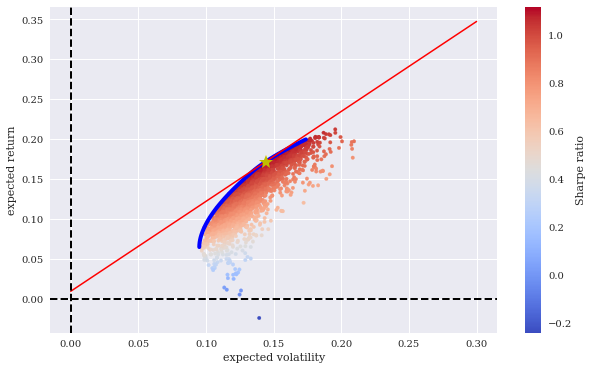

In [66]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=(prets - 0.01) / pvols,marker='.', cmap='coolwarm')
plt.plot(evols, erets, 'b', lw=4.0)
cx = np.linspace(0.0, 0.3)
plt.plot(cx, opt[0] + opt[1] * cx, 'r', lw=1.5)
plt.plot(opt[2], f(opt[2]), 'y*', markersize=15.0)
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

___
# Ejercicios

- Pinta la frontera eficiente de una cartera con los activos **Amazon**, **Berkshire Hathaway Inc Class A**, **The British Petroleum Company**